# Proyecto IA II: Reconocimiento facial


## Obligatorio

In [1]:
#@title **Importar las librerías que se usarán**
import os
import gc
import cv2
import numpy as np
import random
import pandas as pd
import urllib.request
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

# Establecer el crecimiento de la GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
#@title Mount the Drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/2023-1/Proyecto IA')
print(os.getcwd())

Mounted at /content/drive


FileNotFoundError: ignored

In [ ]:
#@title Rutas estandarizadas

# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')

# En la ruta 'data/positive', 'data/negative', 'data/anchor'

## Sección en Jupyter

Primero se establecieron algunas rutas:

```
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
```

*   "POS_PATH" Es la ruta al directorio llamado "positive" dentro de la carpeta "data".
*   "NEG_PATH" Es la ruta al directorio llamado "negative" dentro de la carpeta "data".

Luego, se utilizó la función os.makedirs() para crear los directorios:


```
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)

```

Después de configurar las rutas de acceso y crear los directorios se quería mover las imágenes desde una carpeta llamada "lfw" a la carpeta "negative" pero las imágenes de cada persona estaban en una carpeta individual.



```
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)
```

El bucle exterior for itera sobre los elementos dentro de la carpeta "lfw".
Luego, el bucle interior for itera sobre los archivos dentro de cada directorio de "lfw".

Dentro del bucle, se crean dos rutas de acceso utilizando las variables establecidas anteriormente. EX_PATH representa la ruta de acceso al archivo actual que se está iterando en la carpeta "lfw", mientras que NEW_PATH representa la ruta de acceso a la nueva ubicación del archivo en la carpeta "negative".

Finalmente se utilizó la función os.replace() para mover el archivo desde EX_PATH a NEW_PATH, lo que efectivamente lo traslada de la carpeta "lfw" a la carpeta "negative".


#Pre procesamiento de imágenes

Ajuste de tamaños, normalización

## Ajuste de tamaños

In [ ]:
#@title Ajuste tamaños 200x200px Imágenes Valentina

POS_PATH = os.path.join('data', 'positive')

for filename in os.listdir(POS_PATH):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(POS_PATH, filename)
        image = cv2.imread(img_path)
        if image.ndim == 2:  # Imagen en blanco y negro
            resized_image = cv2.resize(image, (200, 200))
            resized_image = np.expand_dims(resized_image, axis=-1)  # Como algunas están en blanco y negro entonces se debe agregar un canal extra
        else:  # Imagen con tres canales (RGB)
            resized_image = cv2.resize(image, (200, 200))
        cv2.imwrite(img_path, resized_image)

In [ ]:
#@title Ajuste tamaños 200x200px Imágenes de entrenamiento

NEG_PATH = os.path.join('data', 'otro')

for filename in os.listdir(NEG_PATH):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(NEG_PATH, filename)
        image = cv2.imread(img_path)
        resized_image = cv2.resize(image, (200, 200))
        cv2.imwrite(img_path, resized_image)

## Creación ruta de carpetas

In [ ]:
#@title OBLIGATORIO
# Rutas de las carpetas
folderValen = 'data/positive'
folderOthers = 'data/otro'

In [ ]:
#@title OBLIGATORIO
                                                                            #Creaciones de listas

# Crear la lista de archivos de "positive"
valen_files = [filename for filename in os.listdir(folderValen) if filename.endswith('.jpg') or filename.endswith('.png')]

# Crear la lista de archivos de "negative"
others_files = [filename for filename in os.listdir(folderOthers) if filename.endswith('.jpg') or filename.endswith('.png')]

# Lista para almacenar todas las imágenes
all_images = []

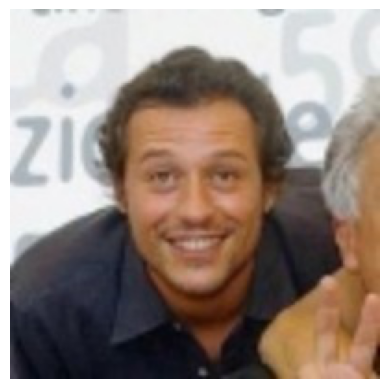

In [ ]:
#@title Mostrar imágen al azar de la carpeta de "otro"

random_image_file = random.choice(others_files)
image_path = os.path.join(folderOthers, random_image_file)

# Leer la imagen y mostrarla
image = mpimg.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

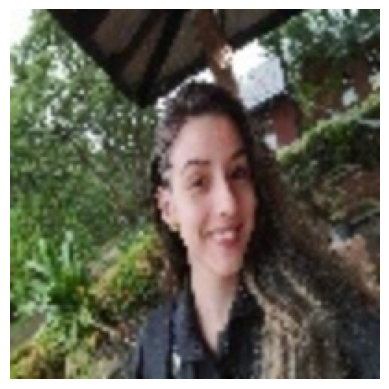

In [ ]:
#@title Mostrar imágen al azar de la carpeta de "Valen"

random_image_file = random.choice(valen_files)
image_path = os.path.join(folderValen, random_image_file)

# Leer la imagen y mostrarla
image = mpimg.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

#Entrenamiento

In [ ]:
# Rutas de los folders de imágenes
folderValen = 'data/positive'
folderOthers = 'data/otro'

# Obtener la lista de archivos de la carpeta "positive" (Valen)
valen_files = [filename for filename in os.listdir(folderValen) if filename.endswith('.jpg') or filename.endswith('.png')]

# Obtener la lista de archivos de la carpeta "negative" (otras personas)
others_files = [filename for filename in os.listdir(folderOthers) if filename.endswith('.jpg') or filename.endswith('.png')]

# Crear listas para almacenar las imágenes y etiquetas
images = []
labels = []

# Asignar la etiqueta positiva
for valen_file in valen_files:
    image_path = os.path.join(folderValen, valen_file)
    image = cv2.imread(image_path)
    images.append(image)
    labels.append(1)  # Etiqueta positiva para imágenes de Valen

# Asignar la etiqueta negativa
for others_file in others_files:
    image_path = os.path.join(folderOthers, others_file)
    image = cv2.imread(image_path)
    images.append(image)
    labels.append(0)  # Etiqueta negativa para imágenes de otras personas


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convertir las listas de imágenes y etiquetas a arrays numpy
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:

# Construir el modelo de CNN
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:


# Entrenar el modelo
history = model.fit(train_images, train_labels, epochs=20, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/20
7/7 [==============================] - 21s 3s/step - loss: 0.9259 - accuracy: 0.8027 - val_loss: 5.0716 - val_accuracy: 0.8214
Epoch 2/20
7/7 [==============================] - 19s 3s/step - loss: 0.3105 - accuracy: 0.9372 - val_loss: 19.0999 - val_accuracy: 0.6250
Epoch 3/20
7/7 [==============================] - 17s 3s/step - loss: 0.2622 - accuracy: 0.9462 - val_loss: 1.0577 - val_accuracy: 0.9286
Epoch 4/20
7/7 [==============================] - 18s 3s/step - loss: 0.3804 - accuracy: 0.9596 - val_loss: 3.0776 - val_accuracy: 0.8750
Epoch 5/20
7/7 [==============================] - 17s 3s/step - loss: 0.4790 - accuracy: 0.9731 - val_loss: 5.9192 - val_accuracy: 0.8750
Epoch 6/20
7/7 [==============================] - 17s 3s/step - loss: 0.1502 - accuracy: 0.9641 - val_loss: 3.0256 - val_accuracy: 0.8929
Epoch 7/20
7/7 [==============================] - 18s 3s/step - loss: 0.1648 - accuracy: 0.9686 - val_loss: 40.0626 - val_accuracy: 0.4821
Epoch 8/20
7/7 [================

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

2/2 [==============================] - 2s 710ms/step - loss: 6.8670 - accuracy: 0.7857
Test accuracy: 0.7857142686843872


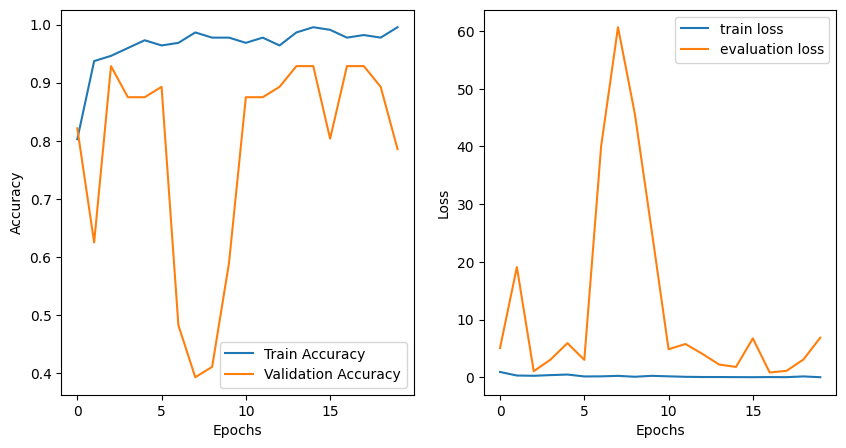

In [ ]:
#@title **Coding**. Gráficos
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');